In [201]:
import numpy as np
import matplotlib.pyplot as plt
import time
import IPython.display
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor, LongTensor
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable as V
from torch.nn import functional as F
print(torch.__version__)
print(torch.cuda.is_available())
use_gpu = torch.cuda.is_available()

0.4.1
True


the number of data points: 16000


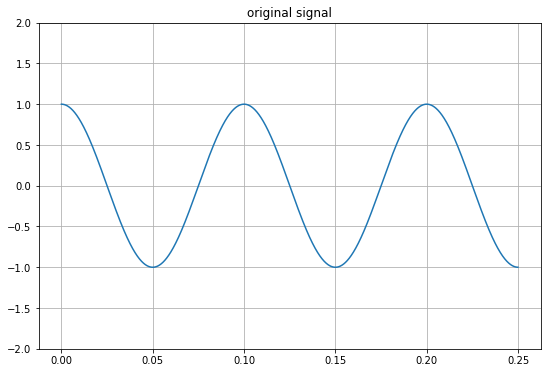

In [202]:
# 学習に使う人工データの生成
sampling_rate = 16000 # サンプリング周波数 [Hz]
len_data = 1.0 # データの波形の長さ [s]
f_original = 10 # 原信号の周波数
t = np.arange(0, len_data, 1 / sampling_rate) # サンプリング点
original_signal = np.cos(2 * np.pi * f_original * t) # 原信号の生成
print('the number of data points:', len(original_signal))

# 原信号を描画する
%matplotlib inline
plt.figure(figsize = (9, 6))
plt.plot(t[:4000], original_signal[:4000])
plt.title('original signal')
plt.ylim([-2.0, 2.0])
plt.grid()
plt.show()

# 原信号を再生する
IPython.display.Audio(original_signal, rate = sampling_rate)

In [203]:
# FM変調
# f_carrierは搬送波の周波数 [Hz]、 MFDは最大周波数偏移 [Hz]
# 参考文献: http://yyatsuo.com/?p=1635
def freq_mod(signal, f, f_carrier, MFD):
    Vm = np.sin(2*np.pi*f_carrier*t + (MFD/f)*np.sin(2*np.pi*f*t))
    return Vm

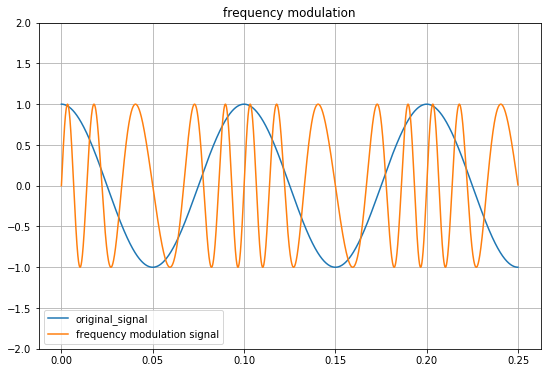

In [204]:
# FM変調信号の生成（搬送波の周波数は比較的大きめに、最大周波数偏移は搬送波の周波数以下にすること）
# 原信号と合わせて描画
fm_signal = freq_mod(original_signal, f_original, 50, 25)
plt.figure(figsize = (9, 6))
plt.plot(t[:4000], original_signal[:4000], label = 'original_signal')
plt.plot(t[:4000], fm_signal[:4000], label = 'frequency modulation signal')
plt.legend(loc = 'lower left')
plt.title('frequency modulation')
plt.ylim([-2.0, 2.0])
plt.grid()
plt.show()

# FM変調信号の再生
IPython.display.Audio(fm_signal, rate = sampling_rate)

In [205]:
# AM変調
# f_carrierは搬送波の周波数 [Hz]
def amp_mod(signal, f, f_carrier):
    Vm = np.cos(2*np.pi*f_carrier*t) + (1/2) * (np.cos(2*np.pi*(f_carrier - f)*t) + np.cos(2*np.pi*(f_carrier - f)*t))
    return Vm

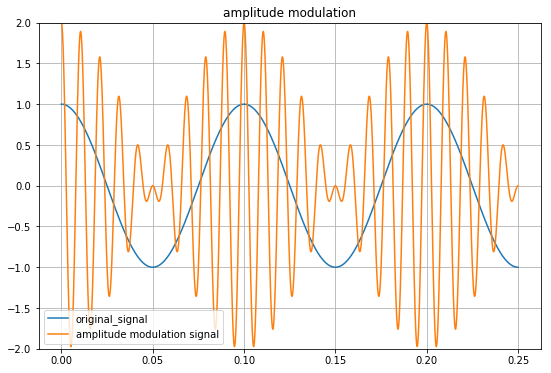

In [206]:
# 搬送波の周波数はFMよりもさらに大きめに取る
am_signal = amp_mod(original_signal, f_original, 100)
plt.figure(figsize = (9, 6))
plt.plot(t[:4000], original_signal[:4000], label = 'original_signal')
plt.plot(t[:4000], am_signal[:4000], label = 'amplitude modulation signal')
plt.legend(loc = 'lower left')
plt.title('amplitude modulation')
plt.ylim([-2.0, 2.0])
plt.grid()
plt.show()

# AM変調信号の再生
IPython.display.Audio(fm_signal, rate = sampling_rate)

In [207]:
# 確率的なノイズを付与する
# ガウシアンノイズ（引数stdは標準偏差）
def add_noise_gaussian(signal, std):
    return signal + np.random.normal(0, std, len(signal))

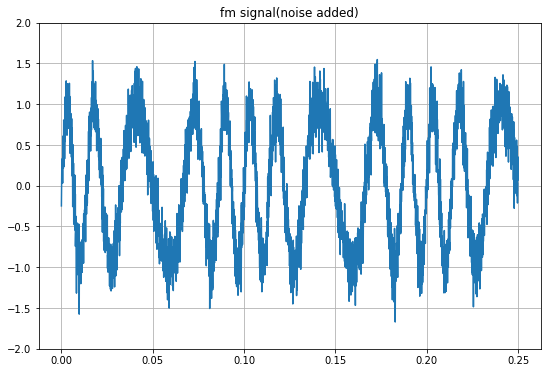

In [311]:
fm_signal_noise = add_noise_gaussian(fm_signal, 0.2)
plt.figure(figsize = (9, 6))
plt.plot(t[:4000], fm_signal_noise[:4000])
plt.title('fm signal(noise added)')
plt.ylim([-2.0, 2.0])
plt.grid()
plt.show()

In [312]:
# 信号の量子化（符号なし8bit） 注：何故か0~255でなく0~254になってしまっている
# 原論文では符号あり16bitに量子化された音声データをμ-lawアルゴリズムで8bitにしているが、今回はひとまず直接8bitにした（後で実装します）
def quantize_8bit(signal):
    signal = signal - np.mean(signal)
    signal = signal / np.max(np.abs(signal))
    signal = np.round(signal * (2 ** 7 - 1))
    signal = (signal + 127).astype(np.uint8)
    return signal

In [313]:
# 取り敢えず一旦今後はFM変調を中心に進める
original_signal_quantized = quantize_8bit(original_signal)
fm_signal_quantized = quantize_8bit(fm_signal)
fm_signal_noise_quantized = quantize_8bit(fm_signal_noise)

In [314]:
# 信号と受容野の広さを受け取り、それに応じたデータセットを作成
# ”受容野の広さ"数分の信号のクラスを入力データ、次の瞬間のクラスを出力データとする
def make_dataset(signal, n):
    X = []
    Y = []
    for i in range(len(signal) - n):
        X.append(signal[i : i+n])
        Y.append(signal[i+n])
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [315]:
# 信号と受容野の広さを受け取ってデータローダーを返す
def make_dataloader(signal, n, testsize = 0.2, batchsize = 64, normalize = True):
    X, Y = make_dataset(signal, n)
    if normalize:
        X = X / 255
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size = testsize)
    ds_train = TensorDataset(Tensor(X_train), LongTensor(Y_train))
    ds_valid = TensorDataset(Tensor(X_valid), LongTensor(Y_valid))
    train_loader = DataLoader(ds_train, batch_size = batchsize, shuffle = True)
    valid_loader = DataLoader(ds_valid, batch_size = batchsize, shuffle = False)
    return train_loader, valid_loader

In [327]:
# データローダーの準備
n_reception = 1024
fm_train_loader, fm_valid_loader = make_dataloader(fm_signal_quantized, n_reception)
fm_noise_train_loader, fm_noise_valid_loader = make_dataloader(fm_signal_noise_quantized, n_reception)

In [328]:
# 単なる多層パーセプトロン
class MLP(nn.Module):
    def __init__(self, n_recep, hidden_size, n_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_recep, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, n_classes)
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        return out

In [329]:
# CNN
# 出力層サイズ = ((入力層サイズ + 2 * パディング - フィルタサイズ) / ストライド) + 1
# ネットワーク構造がまだ未調整なので未実装

In [330]:
# ネットワークの実体化、ロス関数、オプティマイザの定義
net = MLP(n_reception, 1024, 256)
if use_gpu:
    net.cuda()

params = list(net.parameters())
N_params = 0
for p in params:
    N_params += len(p)
print('the number of parameters:', N_params)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

the number of parameters: 4608


In [331]:
def train(train_loader):
    net.train()
    running_loss = 0
    for inputs, targets in train_loader:
        inputs = V(inputs)
        targets = V(targets)
        
        if use_gpu:
            inputs = inputs.cuda()
            targets = targets.cuda()
        
        outputs = net(inputs)
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    return train_loss

In [332]:
def valid(valid_loader):
    net.eval()
    running_loss = 0
    for inputs, targets in valid_loader:
        with torch.no_grad():
            inputs = V(inputs)
            targets = V(targets)
        
            if use_gpu:
                inputs = inputs.cuda()
                targets = targets.cuda()
        
            outputs = net(inputs)
            loss = loss_fn(outputs, targets)
        
        running_loss += loss.item()
    
    valid_loss = running_loss / len(valid_loader)
    
    return valid_loss

In [333]:
# fm変調（ノイズあり）の学習
losses = []
val_losses = []
n_epoch = 20
start = time.time()
for epoch in range(n_epoch):
    loss = train(fm_noise_train_loader)
    val_loss = valid(fm_noise_valid_loader)
    print('epoch[%d/%d] loss:%1.4f val_loss:%1.4f elasped_time:%2.4f' \
           % (epoch+1, n_epoch, loss, val_loss, time.time() - start))
    losses.append(loss)
    val_losses.append(val_loss)
print('elasped_time:%2.4f' % (time.time() - start))

epoch[1/20] loss:4.9767 val_loss:4.5712 elasped_time:0.4477
epoch[2/20] loss:4.4615 val_loss:4.4220 elasped_time:0.8813
epoch[3/20] loss:4.3352 val_loss:4.3172 elasped_time:1.3131
epoch[4/20] loss:4.2781 val_loss:4.2952 elasped_time:1.7426
epoch[5/20] loss:4.2388 val_loss:4.2725 elasped_time:2.1626
epoch[6/20] loss:4.2199 val_loss:4.2851 elasped_time:2.5927
epoch[7/20] loss:4.1958 val_loss:4.2785 elasped_time:3.0300
epoch[8/20] loss:4.1772 val_loss:4.2691 elasped_time:3.4595
epoch[9/20] loss:4.1735 val_loss:4.2835 elasped_time:3.8893
epoch[10/20] loss:4.1608 val_loss:4.2831 elasped_time:4.3149
epoch[11/20] loss:4.1428 val_loss:4.2766 elasped_time:4.7413
epoch[12/20] loss:4.1291 val_loss:4.2893 elasped_time:5.1751
epoch[13/20] loss:4.1172 val_loss:4.2898 elasped_time:5.6110
epoch[14/20] loss:4.1161 val_loss:4.3060 elasped_time:6.0461
epoch[15/20] loss:4.1022 val_loss:4.3061 elasped_time:6.4755
epoch[16/20] loss:4.0995 val_loss:4.3072 elasped_time:6.9022
epoch[17/20] loss:4.0865 val_loss

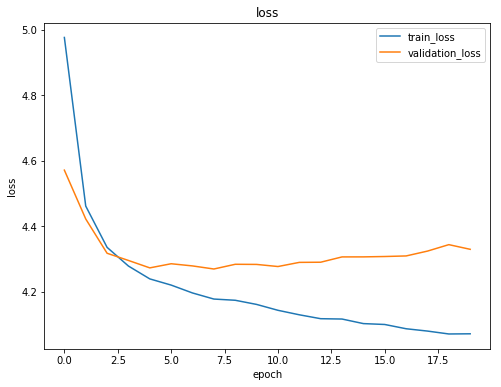

In [334]:
# 学習の様子（ロス）の表示
plt.figure(figsize = (8,6))
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses, label = 'train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.legend()
plt.show()

In [340]:
# 学習のテスト（未来の波形予測）
s_point = 0 # 予測を開始するための初期データの開始地点
n_point = 5000 # 予測する点数
initial_data = fm_signal_noise_quantized[s_point : s_point+n_reception]
initial_data = initial_data / 255

predicted_data = []
predicted_distribution = []
target_data = fm_signal_noise_quantized[s_point+n_reception:]

net.eval()

for n in range(n_point):
    with torch.no_grad():
        inputs = V(Tensor(initial_data).view(1, n_reception))
        if use_gpu:
            inputs = inputs.cuda()
            
        outputs = net(inputs)
        outputs = outputs.view(256)
        
        _, pred = torch.max(outputs.data, 0)
        pred = pred.item()
        
        predicted_data.append(pred)
        predicted_distribution.append(F.softmax(outputs.data, 0))
        initial_data = np.delete(initial_data, 0)
        initial_data = np.append(initial_data, pred / 255)

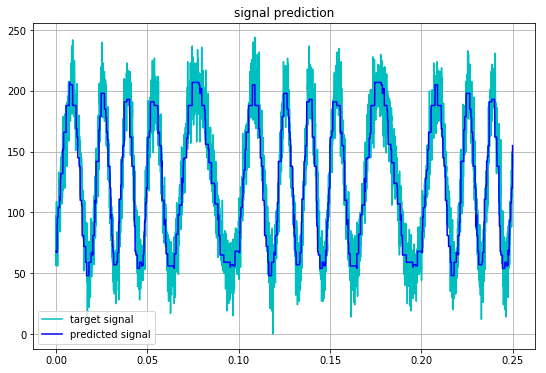

In [341]:
show_start = 0
plt.figure(figsize = (9, 6))
plt.plot(t[show_start : show_start+4000], target_data[show_start : show_start+4000], 'c-', label = 'target signal')
plt.plot(t[show_start : show_start+4000], predicted_data[show_start : show_start+4000], 'b-', label = 'predicted signal')
plt.legend(loc = 'lower left')
plt.title('signal prediction')
plt.grid()
plt.show()

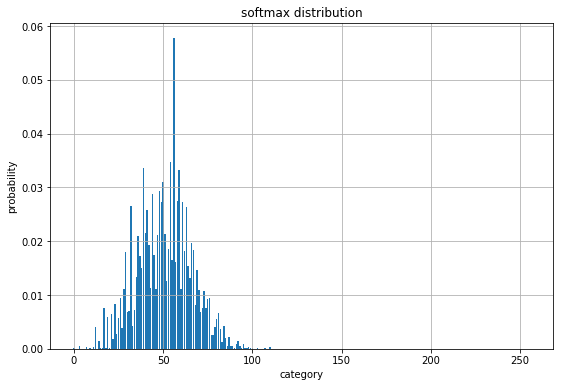

max of predict 56
max of target 58


In [337]:
index = 1000
predicted_dist = predicted_distribution[index].cpu().numpy()
plt.figure(figsize = (9,6))
plt.title('softmax distribution')
plt.xlabel('category')
plt.ylabel('probability')
plt.bar(range(256), predicted_dist)
plt.grid()
plt.show()

print('max of predict', predicted_data[index])
print('max of target', target_data[index])